# recurrent neural network (RNN) + Leu + Val

In [1]:
import json
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

In [3]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)

## has Val and Leu

In [25]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# select
select = df11[0].apply(lambda x: True if ('V' in x and 'L' in x)  else False)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

df21 = df2.drop_duplicates()
df21 = df21.sample(frac=.5)
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
df31 = df31.sample(frac=.4)
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
0
False    1095624
True      769618
Name: count, dtype: int64
(769618, 2)
(3185991, 2) (1592996, 2)
(1863999, 2) (745599, 2)


In [26]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(3108213, 2)


,0,1
299872,LPAEEVDVLL,epitope
1888296,TGFHLEIFPNGTVHGT,other
2463312,QKALGENNN,other
2591952,KNLPFPMLSDIKRELSLATGVLN,other
2190594,CEPAEVLRVSGKTGE,other


In [27]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('epitope', 'LPAEEVDVLL')
Counter({'other': 1592996, 'epitope': 769618, 'random': 745599})


In [28]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('other', 'HESPDIEDFSFK')
split data:  1864927 621642 621644

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: KPGHAMPSLFKVQNVN ['K', 'P', 'G', 'H', 'A', 'M', 'P', 'S', 'L', 'F', 'K', 'V', 'Q', 'N', 'V', 'N']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 2057085), ('V', 1632616), ('S', 1534592), ('A', 1523075), ('G', 1427675), ('E', 1400569), ('P', 1249958), ('K', 1243245), ('R', 1188401), ('T', 1186703), ('D', 1148946), ('I', 1029015), ('Q', 1011350), ('N', 936340), ('F', 882249), ('Y', 742679), ('H', 677458), ('M', 614688), ('C', 613684), ('W', 485094), ('X', 1572), ('U', 43), ('Z', 31), ('B', 26), ('J', 2)])
counts of input: [954689, 462174, 448064]

## Step 3 encoding: encoding each unique token into integers...


In [29]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [30]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.8744 val_acc: 0.8815, val_recall: 0.8590
Epoch 1 acc: 0.8835 val_acc: 0.8843, val_recall: 0.8723
Epoch 2 acc: 0.8855 val_acc: 0.8851, val_recall: 0.8571
Epoch 3 acc: 0.8877 val_acc: 0.8859, val_recall: 0.8607
Epoch 4 acc: 0.8890 val_acc: 0.8869, val_recall: 0.8700
Epoch 5 acc: 0.8902 val_acc: 0.8861, val_recall: 0.8638
Epoch 6 acc: 0.8909 val_acc: 0.8869, val_recall: 0.8619
Epoch 7 acc: 0.8914 val_acc: 0.8870, val_recall: 0.8655
Epoch 8 acc: 0.8918 val_acc: 0.8856, val_recall: 0.8673
Epoch 9 acc: 0.8889 val_acc: 0.8811, val_recall: 0.8595
Epoch 10 acc: 0.8821 val_acc: 0.8759, val_recall: 0.8591
Epoch 11 acc: 0.8733 val_acc: 0.8655, val_recall: 0.8296
Epoch 12 acc: 0.8745 val_acc: 0.8858, val_recall: 0.8662
Epoch 13 acc: 0.8888 val_acc: 0.8860, val_recall: 0.8655
Epoch 14 acc: 0.8912 val_acc: 0.8870, val_recall: 0.8695
Epoch 15 acc: 0.8924 val_acc: 0.8872, val_recall: 0.8706
Epoch 16 acc: 0.8930 val_acc: 0.8873, val_recall: 0.8713
Epoch 17 acc: 0.8932 val_acc: 0.8859, val

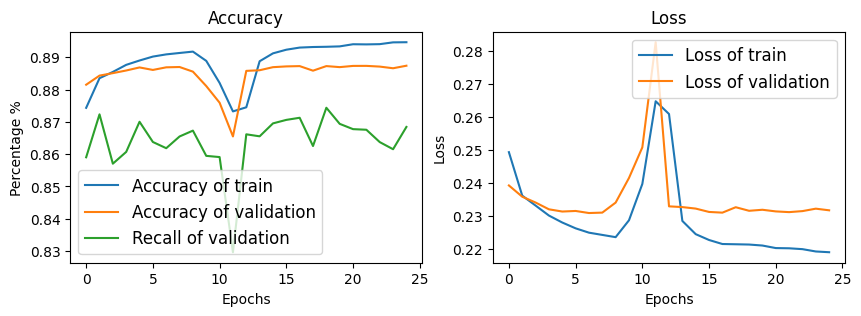

In [31]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [32]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.8687449682577688,
 'accuracy': 0.8878184298408736,
 'loss': 0.23062647885461507}

In [33]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]

153762 467882


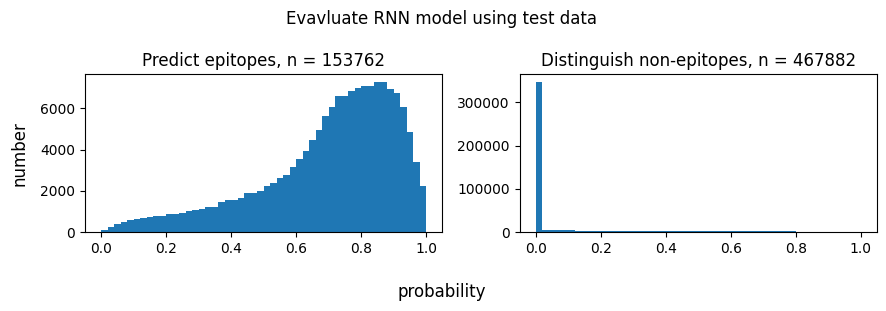

In [34]:
MyEvaluate.plot_prob(pred_test)

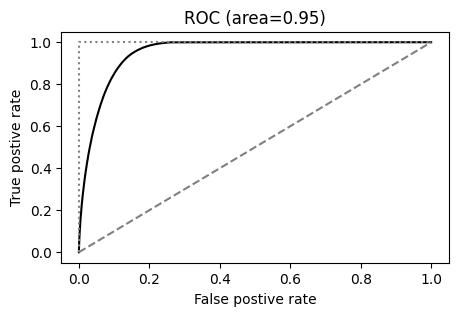

In [35]:
MyEvaluate.plot_roc(pred_test)

In [36]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_Val_Leu.pth')

## without Val and Leu

In [37]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep Cys
select = df11[0].apply(lambda x: True if ('V' not in x and 'L' not in x) else False)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

(1865242, 2) (1865242, 2)
0
False    1652684
True      212558
Name: count, dtype: int64
(212558, 2)


In [38]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)

(2551153, 2)


In [39]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('random', 'HSTCLKNQT')
Counter({'other': 1592996, 'random': 745599, 'epitope': 212558})


In [40]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('other', 'KLYRDSLG')
split data:  1530691 510230 510232

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: DDVVSEDLVQ ['D', 'D', 'V', 'V', 'S', 'E', 'D', 'L', 'V', 'Q']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('S', 1250700), ('L', 1247205), ('A', 1195352), ('G', 1181588), ('E', 1147140), ('P', 1041888), ('K', 979804), ('R', 960621), ('T', 956342), ('D', 922935), ('V', 920297), ('Q', 839551), ('I', 826583), ('N', 753181), ('F', 719033), ('Y', 614638), ('H', 573073), ('C', 559189), ('M', 535539), ('W', 443204), ('X', 1541), ('U', 47), ('Z', 26), ('B', 24), ('J', 1)])
counts of input: [955946, 447144, 127601]

## Step 3 encoding: encoding each unique token into integers...


In [41]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [42]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.9423 val_acc: 0.9462, val_recall: 0.8010
Epoch 1 acc: 0.9476 val_acc: 0.9484, val_recall: 0.7954
Epoch 2 acc: 0.9495 val_acc: 0.9492, val_recall: 0.8041
Epoch 3 acc: 0.9506 val_acc: 0.9494, val_recall: 0.8210
Epoch 4 acc: 0.9515 val_acc: 0.9500, val_recall: 0.8040
Epoch 5 acc: 0.9525 val_acc: 0.9500, val_recall: 0.8137
Epoch 6 acc: 0.9532 val_acc: 0.9502, val_recall: 0.8130
Epoch 7 acc: 0.9538 val_acc: 0.9500, val_recall: 0.8217
Epoch 8 acc: 0.9540 val_acc: 0.9486, val_recall: 0.8262
Epoch 9 acc: 0.9536 val_acc: 0.9502, val_recall: 0.8103
Epoch 10 acc: 0.9545 val_acc: 0.9503, val_recall: 0.8237
Epoch 11 acc: 0.9551 val_acc: 0.9502, val_recall: 0.7994
Epoch 12 acc: 0.9555 val_acc: 0.9500, val_recall: 0.8202
Epoch 13 acc: 0.9558 val_acc: 0.9498, val_recall: 0.8098
Epoch 14 acc: 0.9561 val_acc: 0.9501, val_recall: 0.8192
Epoch 15 acc: 0.9563 val_acc: 0.9499, val_recall: 0.8133
Epoch 16 acc: 0.9565 val_acc: 0.9498, val_recall: 0.8235
Epoch 17 acc: 0.9566 val_acc: 0.9499, val

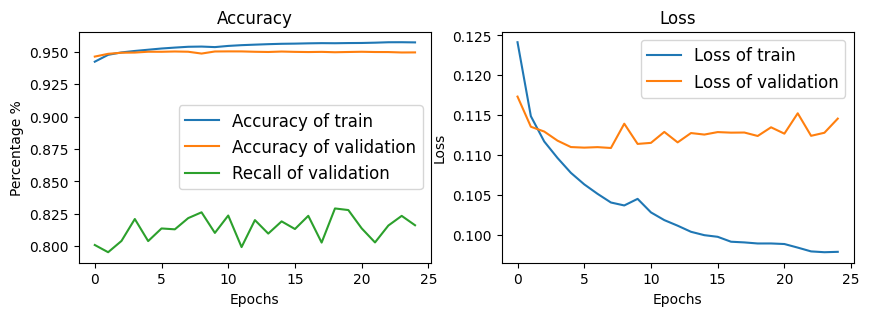

In [43]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [44]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.8164228361892982,
 'accuracy': 0.9492897348657081,
 'loss': 0.1145423865605576}

In [45]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,EEQLRGRNTLKWNYF,4.863759e-08,other
1,ETAQERNET,2.028537e-02,other
2,THSLEQPWT,9.144714e-09,other
3,EIVLNDYK,1.069650e-07,other
4,KFTDFDEVRQ,9.329549e-06,other


42501 467731


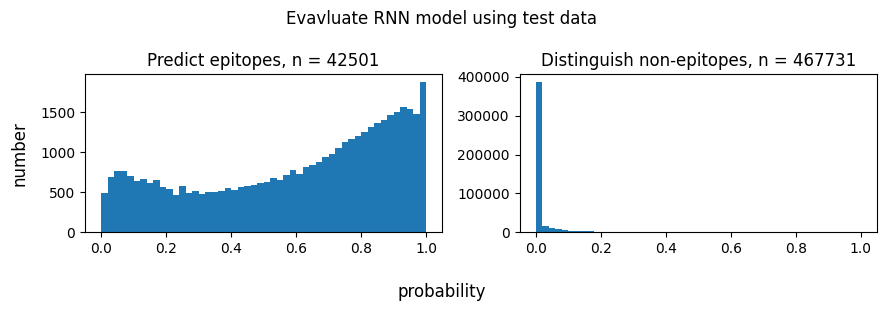

In [46]:
MyEvaluate.plot_prob(pred_test)

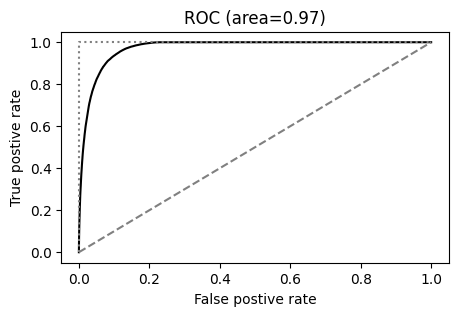

In [47]:
MyEvaluate.plot_roc(pred_test)

In [48]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_notVal_notLeu.pth')